# 🏙️ Extracting Communes with 5000+ Inhabitants


## 📌 Overview
This notebook filters a **communes shapefile** to retain only those with **5000+ inhabitants**, preparing data for mapping.

In [14]:
# IMPORT LIBRARIES
import matplotlib.pyplot as plt
import pandas as pd
import re # For regular expression
import geopandas as gpd # To read geospatial data
from pathlib import Path # To set relative paths
import unidecode # To standardize strings
import py7zr # To unzip files

In [15]:
# GETTING PROJECT'S ROOT DIRECTORY
base_folder = Path().resolve()  # CURRENT WORKING DIRECTORY
main_folder = base_folder.parent

In [16]:
# EXTRACTING COMMUNES ZIPPED SHAPEFILE
seven_zip_path = main_folder / "data" / "shapefiles" / "Communes" / "communes-20220101.shp.7z"
extract_dir = main_folder / "data" / "shapefiles" / "Communes"

with py7zr.SevenZipFile(seven_zip_path, mode='r') as archive:
    archive.extractall(path=extract_dir)

In [17]:
# SETTING ALL NECESSARY DIRECTORIES
shapefile_path = main_folder / "data" / "shapefiles" / "Communes" / "communes-20220101.shp"
stmt_path = main_folder / "data" / "1- Raw Data" / "STMT" / "Janvier 2020 STMT.csv"
output_path1 = main_folder / "data" / "2- Formatted Data" / "full_stmt_dataset_cleaned_v2.csv"
output_path2 = main_folder / "data" / "2- Formatted Data" / "name_communes_5000.csv"

In [20]:
%%capture

# IMPORTING FILES
communes_shp = gpd.read_file(shapefile_path)
stmt_df = pd.read_csv(stmt_path, skiprows=3, delimiter=';', encoding='utf-8', skip_blank_lines=True)

In [21]:
# EXPLORING FILES AND SMALL ADJUSTMENTS
communes_shp.rename(columns={"nom": "commune"}, inplace=True)
communes_shp.head(5)

,insee,commune,wikipedia,surf_ha,geometry
0,2B222,Pie-d'Orezza,fr:Pie-d'Orezza,573.0,"POLYGON ((9.3202 42.385, 9.3203 42.385, 9.3205..."
1,2B137,Lano,fr:Lano,824.0,"POLYGON ((9.2001 42.39, 9.2001 42.39, 9.2003 4..."
2,2B051,Cambia,fr:Cambia,833.0,"POLYGON ((9.2776 42.375, 9.2776 42.375, 9.2777..."
3,2B106,Érone,fr:Érone,393.0,"POLYGON ((9.2512 42.376, 9.2513 42.376, 9.2517..."
4,2B185,Oletta,fr:Oletta,2674.0,"POLYGON ((9.2834 42.663, 9.2835 42.663, 9.2835..."


In [25]:
# Split 'Commune de plus de 5000 hab' into commune name and postal code
stmt_df[['commune_5000', 'postal_code']] = stmt_df["Commune de plus de 5000 hab."].str.rsplit(' ', n=1, expand=True)
stmt_df.head(5)

,Commune de plus de 5000 hab.,A1101 : Conduite d'engins d'exploitation agricole et forestière,A1201 : Bûcheronnage et élagage,A1202 : Entretien des espaces naturels,A1203 : Entretien des espaces verts,A1204 : Protection du patrimoine naturel,A1205 : Sylviculture,A1301 : Conseil et assistance technique en agriculture,A1302 : Contrôle et diagnostic technique en agriculture,A1303 : Ingénierie en agriculture et environnement naturel,...,N4204 : Technicien d'exploitation des transports routiers de personnes,N4301 : Conduite sur rails,N4302 : Contrôle des transports en commun,N4401 : Circulation du réseau ferré,N4402 : Exploitation et manoeuvre des remontées mécaniques,N4403 : Manœuvre du réseau ferré,"ZZZZZ : Autre RomeV3, non renseigné",Total,commune_5000,postal_code
0,Abbeville 80100,0,10,20,90,0,0.0,0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,20,1 900,Abbeville,80100
1,Ablon-sur-Seine 94480,0,0,0,0,0,0.0,0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,240,Ablon-sur-Seine,94480
2,Achères 78260,0,0,0,20,0,0.0,0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,10,1 270,Achères,78260
3,Achicourt 62217,0,0,0,10,0,0.0,0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,10,410,Achicourt,62217
4,Acigné 35690,0,0,0,0,0,0.0,0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,250,Acigné,35690


### The objective is to match our "commune_5000" column with the "commune" column to align geospatial information for future mapping.

1- STANDARDIZATION OF COMMUNE COLUMN FROM BOTH DATASET

In [26]:
# Standardization function
def standardize_commune(name):
    if pd.isna(name):
        return None
    name = unidecode.unidecode(name.lower().strip())  # Remove accents & lowercase
    name = re.sub(r"[-'’]", " ", name)  # Remove hyphens & apostrophes
    name = re.sub(r"\bst[ .]", "saint ", name)  # Standardize "St." -> "Saint"
    return name

# Apply standardization
stmt_df["commune_5000"] = stmt_df["commune_5000"].apply(standardize_commune)
communes_shp["commune"] = communes_shp["commune"].apply(standardize_commune)

# Merge datasets
df_merged = stmt_df.merge(communes_shp, left_on="commune_5000", right_on="commune", how="left")

2- WHICH COMMUNES WERE NOT MATCHED AND WHY?

In [27]:
# Extract unique unmatched commune names as a list
unique_unmatched_communes_list = df_merged.loc[df_merged["commune"].isna(), "commune_5000"].drop_duplicates().tolist()

# Print the list
print(unique_unmatched_communes_list)

# Definining a function that tries to find potential match using regex expressions
def regex_search(commune_name, commune_list):
    pattern = re.sub(r"\s+", ".*", commune_name)  # Convert spaces to regex wildcard
    matches = [c for c in commune_list if re.search(pattern, c, re.IGNORECASE)]
    return matches

# Check possible regex matches
possible_matches = {c: regex_search(c, communes_shp["commune"].tolist()) for c in unique_unmatched_communes_list}

# Print potential matches
for key, value in possible_matches.items():
    if value:
        print(f"🔍 Possible match for '{key}': {value}")
        
# Drop unmtached values
df_merged = df_merged[~df_merged["commune_5000"].isin(unique_unmatched_communes_list)]

['ancenis', 'aubevoye', 'beaufort en vallee', 'beaupreau', 'bellegarde sur valserine', 'boulazac', 'briey', 'brunstatt', 'carentan', 'chateau gontier', 'chemille melay', 'cherbourg octeville', 'clichy', 'conde sur noireau', 'doue la fontaine', 'faverges', 'grandchamps des fontaines', 'herblay', 'jaunay clan', 'l  ile d yeu', 'la chapelle basse mer', 'lamballe', 'le chesnay', 'les arcs', 'les avenieres', 'machecoul', 'malemort sur correze', 'malesherbes', 'notre dame de gravenchon', 'orvanne', 'penmarch', 'saint christol les ales', 'saint macaire en mauges', 'segre', 'templeuve', 'teteghem', 'theix', 'verneuil sur avre', 'communes de moins de 5 000 habitants ou donnees', 'total', 'les donnees presentees dans ce tableau sont arrondies a la dizaine. pour cette raison, la somme des valeurs d une ligne (ou d une colonne) peut legerement differer du total']
🔍 Possible match for 'ancenis': ['ancenis saint gereon']
🔍 Possible match for 'beaupreau': ['beaupreau en mauges']
🔍 Possible match for 

#### Looking online at the unmatched communes, the issue arises because the shapefile dates from 2022, while the dataset is from 2020. Over the years, some communes have merged, extending their names. However, most of these mergers occurred before 2020, yet the STMT data still contains old commune names. A likely explanation is that administrative and employment service records still use these older commune names. While we could attempt to merge communes, for simplicity, we will drop these approximately 40 communes (0.9% of our sample).

3- QUICK VISUALISATION

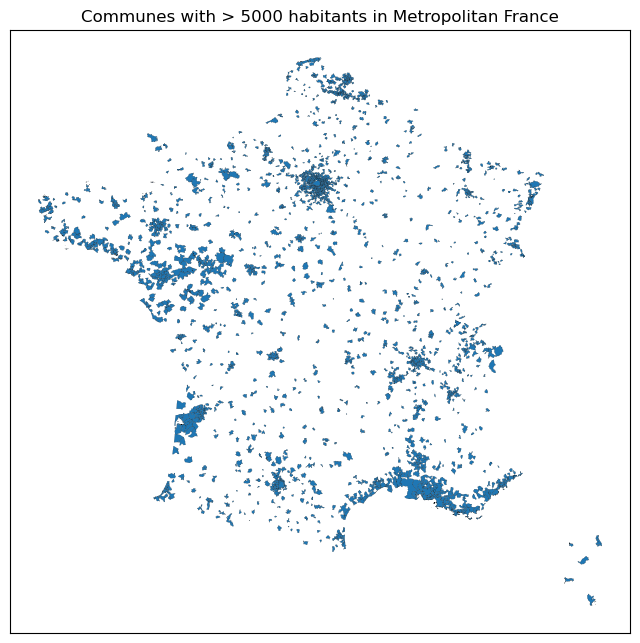

In [33]:
# Reconvert into geospatial dataframe
gdf = gpd.GeoDataFrame(df_merged, geometry="geometry")

# Define approximate bounding box for mainland France & Corsica
france_bounds = (-5, 10, 41, 52)  # (xmin, xmax, ymin, ymax)

# Filter to keep only polygons within this bounding box
gdf_mainland = gdf.cx[france_bounds[0]:france_bounds[1], france_bounds[2]:france_bounds[3]]

# Plot with very thin edges
fig, ax = plt.subplots(figsize=(8, 10))
gdf_mainland.plot(ax=ax, edgecolor="black", linewidth=0.1, alpha=1)

# Remove axis labels for cleaner visualization
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Communes with > 5000 habitants in Metropolitan France")

plt.show()

4- SAVE AND EXPORT

In [12]:
# EXPORT LIST OF COMMUNES 5000 HABITANTS
commune_5000_unique = df_merged["commune_5000"].drop_duplicates()
commune_5000_unique.to_csv(output_path2, index=False)